In [6]:
import sys
sys.path.insert(0, '/home/reza/erq')
from scipy import interpolate
# import pyfits
from numpy import *
import math
import scipy.ndimage
from scipy import interpolate
from numpy import nanmean
from numpy import nanmedian
from readSDSSspectrafast import *
import matplotlib.pylab as plt
import numpy as np
from erqml import *
from scipy import ndimage
from line_db import line_db
import os
import tqdm
## Define a log wavelength grid for the composite spectrum
step = 1.00015
bb = arange(0,8813,1)
wgrid = 800.0 * step**bb

# Insert code here to read data for all possible quasars (redshift, colors, line data, etc.)

from astropy.table import Table, Column
# SMALL_SIZE = 20
# MEDIUM_SIZE = 20
# BIGGER_SIZE = 20

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# # 



# selection parameters
tab=Table.read('/home/reza/erq/sampling/LM_sample.fits')
# This 2D array will hold all the spectra used for the median below
# selection parameters
z_dr12=tab['z_dr12']
plate = tab['Plate']
mjd = tab['MJD']
fiberid= tab['FiberID']

#  parametres 
W3 = tab['ABw3']
imw3 =tab['i-w3']
REW = tab['rew_gf']
FWHM = tab['fwhm_gf']
kt80 = tab['kurt80_gf']
frat_civ_nv = tab['frat_nv/civ']
rw3=tab['r-w3']
rz=tab['r-z']
iz= imw3 - rw3 + rz
Lum = tab['Lum']

In [7]:
nqsos = len(z_dr12)
bw=2.0
# BW=[3.0]
tip_label=np.loadtxt('bw-2.00/tip_label-bw-2.00.txt')
tip_pop = int(sum(tip_label))
enclosing_ratio=0.75
Omega= [11.02]
bin_label1=np.loadtxt('bw-2.00/enc-r-%.2f/bin_label-bw-%.2f-wdg-%d.txt' 
                      %(enclosing_ratio, bw,1))
bin_label5=np.loadtxt('bw-2.00/enc-r-%.2f/bin_label-bw-%.2f-wdg-%d.txt' 
                      %(enclosing_ratio, bw,5))
bin_pop1=np.loadtxt('bw-2.00/enc-r-%.2f/bin_pop-bw-%.2f-wdg-%d.txt' 
                    %(enclosing_ratio, bw, 1))
bin_pop5=np.loadtxt('bw-2.00/enc-r-%.2f/bin_pop-bw-%.2f-wdg-%d.txt' 
                    %(enclosing_ratio, bw, 5))

bin_label15=np.zeros([nqsos])

for j in range(nqsos):
#     if(bin_label1[j]==1 or bin_label1[j]==2): bin_label15[j]=6
#     if(bin_label1[j]==3 or bin_label1[j]==4): bin_label15[j]=7
#     if(bin_label1[j]==5 or bin_label1[j]==6): bin_label15[j]=8
#     if(bin_label1[j]==7 or bin_label1[j]==8): bin_label15[j]=9
#     if(bin_label1[j]==9): bin_label15[j]=10
        
#     if(bin_label5[j]==8 or bin_label5[j]==7): bin_label15[j]=2
#     if(bin_label5[j]==6 or bin_label5[j]==5): bin_label15[j]=3
#     if(bin_label5[j]==4 or bin_label5[j]==3): bin_label15[j]=4
#     if(bin_label5[j]==2 or bin_label5[j]==1): bin_label15[j]=5
#     if(bin_label5[j]==9): bin_label15[j]=1
    for i in range(1,10):
        if(bin_label5[j]==i): bin_label15[j]=10-i
        if(bin_label1[j]==i): bin_label15[j]=i+9
        
    
    

bin_label15=np.array(bin_label15, dtype=np.int32)
print(np.unique(bin_label15))
bin_pop15=np.zeros([np.max(np.unique(bin_label15))])
for i in range(0,np.max(np.unique(bin_label15))):
    pops = bin_label15[bin_label15==i+1]
    bin_pop15[i] =len(pops)


[ 0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [59]:
bin_pop1

array([393., 309., 152.,  82.,  50.,  46.,  24.,  19.,  37.])

In [60]:
bin_pop5

array([638., 183.,  65.,  29.,  22.,  24.,   5.,   0.,   0.])

In [61]:
bin_pop15

array([  0.,   0.,   5.,  24.,  22.,  29.,  65., 183., 638., 393., 309.,
       152.,  82.,  50.,  46.,  24.,  19.,  37.])

In [62]:
#  Med-Spec
step = 1.00015
bb = arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)

enclosing_ratio=0.75

    
bin_pop = bin_pop15
bin_id = bin_label15
for b in range(len(bin_pop)):
    print('enc-r:', enclosing_ratio,  
    'bin:', b, '#', bin_pop[b])
    if(bin_pop[b]>5):

        sp = zeros([int(bin_pop[b]), nw])
        k=-1
        for i in (range(nqsos)):
            if(bin_id[i]==b+1):
                k+=1
            # Retrieve the spectra:
                file = '/home/reza/erq/fred/sdss/%d/spec-%d-%d-%04d.fits' % (plate[i], plate[i],mjd[i],fiberid[i])
                spec = readDR10spec(file)
                wave = spec['wl']
                wz = wave/(z_dr12[i]+1)
                flux = spec['flux']
                mask = (wz > 1680.0) & (wz < 1730.0)
                fnorm = median(flux[mask])
                fluxn = flux/fnorm
            # interpolate the rest-frame spectrum onto the standard grid
                f = interpolate.interp1d(wz,fluxn,bounds_error=False,fill_value=float('nan'))
                sp[k] = f(wgrid)
            # calculate the median spectrum

        med1 = nanmedian(sp,axis=0)
        savetxt( 'bw-2.00/enc-r-%.2f/kde-medspec-bin-%d-wdge-%.2f.txt' 
        %(enclosing_ratio, b, 15), med1)



enc-r: 0.75 bin: 0 # 0.0
enc-r: 0.75 bin: 1 # 0.0
enc-r: 0.75 bin: 2 # 5.0
enc-r: 0.75 bin: 3 # 24.0


/home/reza/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


enc-r: 0.75 bin: 4 # 22.0
enc-r: 0.75 bin: 5 # 29.0
enc-r: 0.75 bin: 6 # 65.0
enc-r: 0.75 bin: 7 # 183.0
enc-r: 0.75 bin: 8 # 638.0


/home/reza/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


enc-r: 0.75 bin: 9 # 393.0
enc-r: 0.75 bin: 10 # 309.0
enc-r: 0.75 bin: 11 # 152.0
enc-r: 0.75 bin: 12 # 82.0
enc-r: 0.75 bin: 13 # 50.0
enc-r: 0.75 bin: 14 # 46.0
enc-r: 0.75 bin: 15 # 24.0
enc-r: 0.75 bin: 16 # 19.0
enc-r: 0.75 bin: 17 # 37.0


bin: 17 1000 to 1980
bin: 16 1000 to 1980
bin: 15 1000 to 1980
bin: 14 1000 to 1980
bin: 13 1000 to 1980
bin: 12 1000 to 1980
bin: 11 1000 to 1980
bin: 10 1000 to 1980
bin: 9 1000 to 1980
bin: 8 1000 to 1980
bin: 7 1000 to 1980
bin: 6 1000 to 1980
bin: 5 1000 to 1980
bin: 4 1000 to 1980
bin: 3 1000 to 1980
bin: 2 1000 to 1980


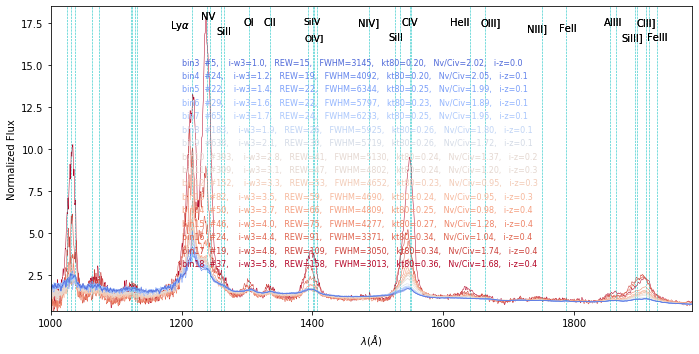

bin: 17 1150 to 1980
bin: 16 1150 to 1980
bin: 15 1150 to 1980
bin: 14 1150 to 1980
bin: 13 1150 to 1980
bin: 12 1150 to 1980
bin: 11 1150 to 1980
bin: 10 1150 to 1980
bin: 9 1150 to 1980
bin: 8 1150 to 1980
bin: 7 1150 to 1980
bin: 6 1150 to 1980
bin: 5 1150 to 1980
bin: 4 1150 to 1980
bin: 3 1150 to 1980
bin: 2 1150 to 1980


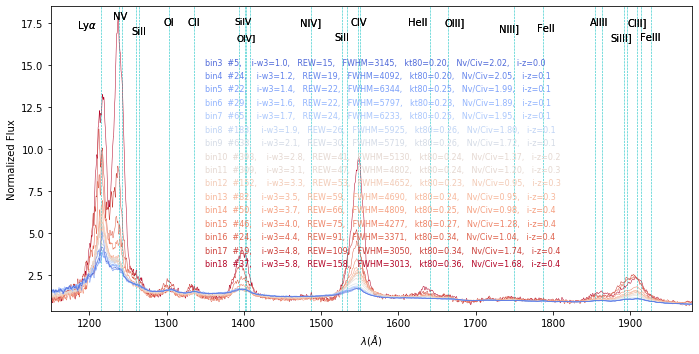

bin: 17 1150 to 2850
bin: 16 1150 to 2850
bin: 15 1150 to 2850
bin: 14 1150 to 2850
bin: 13 1150 to 2850
bin: 12 1150 to 2850
bin: 11 1150 to 2850
bin: 10 1150 to 2850
bin: 9 1150 to 2850
bin: 8 1150 to 2850
bin: 7 1150 to 2850
bin: 6 1150 to 2850
bin: 5 1150 to 2850
bin: 4 1150 to 2850
bin: 3 1150 to 2850
bin: 2 1150 to 2850


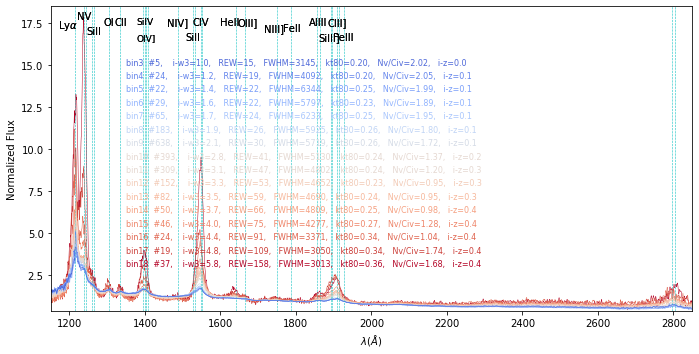

bin: 17 1150 to 1700
bin: 16 1150 to 1700
bin: 15 1150 to 1700
bin: 14 1150 to 1700
bin: 13 1150 to 1700
bin: 12 1150 to 1700
bin: 11 1150 to 1700
bin: 10 1150 to 1700
bin: 9 1150 to 1700
bin: 8 1150 to 1700
bin: 7 1150 to 1700
bin: 6 1150 to 1700
bin: 5 1150 to 1700
bin: 4 1150 to 1700
bin: 3 1150 to 1700
bin: 2 1150 to 1700


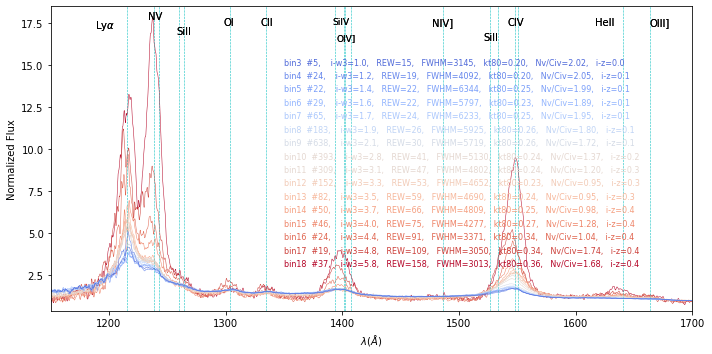

In [12]:
from matplotlib import cm
c = cm.get_cmap('coolwarm', 16)
# c=['C0', 'C1', 'C2','C3', 'C4', 'C5', 'C6', 'darkred',  'black', 'lightblue', ]
ymax=18.5
ymin=0.02*ymax
fs=10
fs1=9
y_median = 0.95*ymax
med_step=.8
legend_loc=7
#         if(dir==1 and enclosing_ratio>0.75): 
#             ymax=18.0; ymin=0.01*ymax; fs=10; fs1=9; x_median=1280; 
#             y_median = 0.83*ymax; med_step=0.7; legend_loc=7
#         if(dir==1 and enclosing_ratio<=0.75): 
#             ymax=18.5; ymin=0.01*ymax; fs=10; 
#             fs1=9; x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=1
#         if(dir==2 and enclosing_ratio>=0.9): 
#             ymax=16; ymin=0.01*ymax; fs=10; fs1=9; 
#             x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=7
#         if(dir==2 and enclosing_ratio<0.9): 
#             ymax=15; ymin=0.01*ymax; fs=10; fs1=9; 
#             x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=7
#         if(dir==3 and enclosing_ratio>=0.9): 
#             ymax=9; ymin=0.01*ymax; fs=10; fs1=9; 
#             x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=7
#         if(dir==3 and enclosing_ratio<0.9): 
#             ymax=11; ymin=0.01*ymax; fs=10; fs1=9; 
#             x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=7
#         if(dir==4 or dir==5): 
#             ymax=5.5; ymin=0.05*ymax; fs=10; fs1=9; 
#             x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=7

for ii in range(0,4):

    if(ii==0): lambda_min = 1000; lambda_max = 1980
    if(ii==1): lambda_min = 1150; lambda_max = 1980
    if(ii==2): lambda_min = 1150; lambda_max = 2850
    if(ii==3): lambda_min = 1150; lambda_max = 1700
    fig = plt.figure(figsize=(11.5,5.6))
    line_db(ymax, fs, fs1, lambda_max)

    plt.xlim(lambda_min,lambda_max)
    plt.ylim(ymin, ymax)
    # plt.axes().set_aspect('equal')
    x_median=lambda_min+200


    for b in range(len(bin_pop15)-1,-1,-1):
#     for b in range(len(bin_pop)):

        if(bin_pop15[b]>=5):   
            print('bin:', b, lambda_min, 'to', lambda_max)
            med1=loadtxt('bw-2.00/enc-r-%.2f/kde-medspec-bin-%d-wdge-%.2f.txt'
                         %(enclosing_ratio, b, 15))
            plt.ylabel('Normalized Flux')
            plt.xlabel(r'$\lambda  (\AA)$')
            w3_bin=[]
            imw3_bin=[]
            REW_bin=[]
            fwhm_bin=[]
            kt80_bin=[]
            frat_bin=[]
            iz_bin=[]
            Lum_bin=[]

            for i in range(nqsos):
                if(bin_label15[i]==b+1):
                    w3_bin.append(W3[i]) 
                    imw3_bin.append(imw3[i])
                    REW_bin.append(REW[i])
                    fwhm_bin.append(FWHM[i])
                    kt80_bin.append(kt80[i])
                    frat_bin.append(frat_civ_nv[i])
                    iz_bin.append(iz[i])
                    Lum_bin.append(Lum[i])
            if(bin_pop15[b]<100):
                sm_med1 = ndimage.filters.gaussian_filter1d(med1,2.0)
            else:
                sm_med1=med1

            # masking for plot ranges
            ind = (wgrid>lambda_min) & (wgrid<lambda_max)
            plt.text(x_median, y_median -(b+1)*med_step,
                     'bin%d  #%d,    i-w3=%.1f,   REW=%d,   FWHM=%d,   kt80=%.2f,   Nv/Civ=%.2f,   i-z=%.1f' 
                     %(b+1, bin_pop15[b], np.median(imw3_bin),  
                        np.median(REW_bin), np.median(fwhm_bin),  
                        np.median(kt80_bin), np.median(frat_bin), 
                        np.median(iz_bin)), 
                     ha='left', va='center', color=c(b/len(bin_pop15)), fontsize=8)
            plt.plot(wgrid[ind],  sm_med1[ind], lw = .5, c=c(b/len(bin_pop15)), 
                     label='bin-%d #%d' %(b+1, bin_pop15[b]))
#     tip_spec = loadtxt('bw-2.00/medspec-tip.txt')            
#     plt.plot(wgrid[ind],  tip_spec[ind], lw = 2,
#              label = 'typical #%d' %(tip_pop), c = 'gray', alpha=0.4)
#             plt.legend(fancybox=True, framealpha=0.3, loc=legend_loc)
    line_db(ymax, fs, fs1, lambda_max)
#     plt.title(r'$\Omega=%.2f, \theta=%.2f$' %(Omega[kk], 32.09))
    os.system('mkdir bw-2.00/enc-r-%.2f/med-spec' %enclosing_ratio)
    fig_path = 'bw-2.00/enc-r-%.2f/med-spec/%d-%d-dir-%d.pdf'%(enclosing_ratio, lambda_min, lambda_max, 15)
    plt.savefig(fig_path, format='pdf',  bbox_inches='tight')
    plt.savefig('/home/reza/erq/paper/draft-mnras/fig/bw-0.75/%d-%d-dir-%d.pdf'
                %( lambda_min, lambda_max,15)
  , format='pdf',  bbox_inches='tight')
    
    # os.system('evince '+ fig_path)
    # plt.savefig('/home/reza/erq/kde/bw/enc-r-%.2f/test.pdf' %(enclosing_ratio),format='pdf',  bbox_inches='tight')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

In [38]:
enclosing_ratio

0.75